# Phase 4: Comprehensive Multi-Factor Scoring & Course Graph Analysis (Optimized)

**Goals**:
1. **Multi-Factor Difficulty Score** (with potential advanced refinements):
   - Combine multiple metrics (GPA stats, fraction of A, drop_rate, workload, etc.).
   - Possibly verify or tune weights via correlation/PCA analysis.
2. **Course Graph**:
   - Build a directed graph from prerequisite data.
   - Attach difficulty scores to nodes.
   - Explore advanced layouts (kamada_kawai_layout, graphviz_layout) and partial subgraphs to avoid clutter.
3. **Path Recommendations**:
   - Dijkstra-based minimal difficulty route.
   - Potential expansions to multi-path or layered drawings.
4. **Export / Visualization**:
   - Demo how to reduce large graphs or to export for use in Gephi, Cytoscape, or PyVis for interactive analysis.

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

%matplotlib inline

In [3]:
cleaned_path = os.path.join("..", "data", "cleaned_grades.pkl")
df = pd.read_pickle(cleaned_path)

print("Loaded cleaned DataFrame from Phase 1.")
print(f"Shape: {df.shape}")
display(df.head(5))

df_computable = df[df["gpa_status"] == "computable"].copy()
print("\nComputable GPA rows:", len(df_computable))

agg_dict = {
    "enhanced_calculated_gpa": ["mean", "std", "count"]
}
if "frac_A_range" in df_computable.columns:
    agg_dict["frac_A_range"] = ["mean"]
# etc. for drop_rate, workload...

course_df = df_computable.groupby("Course").agg(agg_dict)
course_df.columns = ["_".join(col).strip() for col in course_df.columns.values]
course_df = course_df.fillna(0)

Loaded cleaned DataFrame from Phase 1.
Shape: (9454, 10)


,Submission time,User ID,Term,Course,Professor,Grade distribution,Recommend professor?,enhanced_grade_dict,enhanced_calculated_gpa,gpa_status
0,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 120,"Voelker, Geoffrey M.","A+:11, A:41, A-:25, B+:41, B:28, B-:16, C+:12,...",NaN,"{'a+': 11, 'a': 41, 'a-': 25, 'b+': 41, 'b': 2...",3.137864,computable
1,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 132A,"Vianu, Victor Dan","A+:4, A:23, A-:19, B+:40, B:15, B-:27, C+:15, ...",NaN,"{'a+': 4, 'a': 23, 'a-': 19, 'b+': 40, 'b': 15...",2.966463,computable
2,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 141L,"Eldon, John","A+:1, A:28, A-:4, B+:2, B:0, B-:3, C+:0, C:3, ...",NaN,"{'a+': 1, 'a': 28, 'a-': 4, 'b+': 2, 'b': 0, '...",3.366667,computable
3,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 167,"Li, Tzumao","A+:102, A:22, A-:11, B+:5, B:7, B-:6, C+:2, C:...",NaN,"{'a+': 102, 'a': 22, 'a-': 11, 'b+': 5, 'b': 7...",3.709756,computable
4,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 230,"Jhala, Ranjit","A+:29, A:42, A-:26, B+:16, B:7, B-:1, C+:0, C:...",NaN,"{'a+': 29, 'a': 42, 'a-': 26, 'b+': 16, 'b': 7...",3.743443,computable



Computable GPA rows: 8664


In [4]:
course_df["avg_gpa"] = course_df["enhanced_calculated_gpa_mean"]
course_df["std_gpa"] = course_df["enhanced_calculated_gpa_std"]
course_df["frac_A"]  = course_df["frac_A_range_mean"] if "frac_A_range_mean" in course_df.columns else 0
course_df["drop"]    = course_df["drop_rate_mean"] if "drop_rate_mean" in course_df.columns else 0
course_df["work"]    = course_df["workload_mean"] if "workload_mean" in course_df.columns else 0

factors = pd.DataFrame(index=course_df.index)
factors["avg_gpa"]   = course_df["avg_gpa"]    # invert
factors["std_gpa"]   = course_df["std_gpa"]
factors["frac_A"]    = course_df["frac_A"]     # invert
factors["drop"]      = course_df["drop"]
factors["work"]      = course_df["work"]

factors["inv_gpa"]   = -factors["avg_gpa"]
factors["inv_fracA"] = -factors["frac_A"]

feature_cols = ["inv_gpa", "std_gpa", "inv_fracA", "drop", "work"]

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(factors[feature_cols])
scaled_df = pd.DataFrame(scaled_values, columns=[col+"_scaled" for col in feature_cols], index=factors.index)

course_df = pd.concat([course_df, scaled_df], axis=1)

weights = {
    "inv_gpa_scaled": 0.3,
    "std_gpa_scaled": 0.2,
    "inv_fracA_scaled": 0.2,
    "drop_scaled": 0.2,
    "work_scaled": 0.1
}

def compute_difficulty(row):
    total = 0
    for col, w in weights.items():
        total += row[col] * w
    return total

course_df["difficulty_score"] = course_df.apply(compute_difficulty, axis=1)
course_df_sorted = course_df.sort_values("difficulty_score", ascending=False)

print("Top 10 courses (hardest):")
display(course_df_sorted.head(10))
print("\nBottom 10 courses (easiest):")
display(course_df_sorted.tail(10))

Top 10 courses (hardest):


,enhanced_calculated_gpa_mean,enhanced_calculated_gpa_std,enhanced_calculated_gpa_count,avg_gpa,std_gpa,frac_A,drop,work,inv_gpa_scaled,std_gpa_scaled,inv_fracA_scaled,drop_scaled,work_scaled,difficulty_score
Course,,,,,,,,,,,,,,
MATH 3C,2.201124,0.723881,29,2.201124,0.723881,0,0,0,0.759743,0.688117,0.0,0.0,0.0,0.365546
HILD 10,2.630625,0.881894,4,2.630625,0.881894,0,0,0,0.578346,0.838324,0.0,0.0,0.0,0.341169
MAE 30B,2.520790,0.772817,10,2.520790,0.772817,0,0,0,0.624734,0.734635,0.0,0.0,0.0,0.334347
MUS 13,3.107494,1.051973,2,3.107494,1.051973,0,0,0,0.376944,1.000000,0.0,0.0,0.0,0.313083
MATH 2,1.632258,0.045620,2,1.632258,0.045620,0,0,0,1.000000,0.043366,0.0,0.0,0.0,0.308673
MATH 140A,2.479446,0.411826,33,2.479446,0.411826,0,0,0,0.642196,0.391479,0.0,0.0,0.0,0.270955
ECE 30,2.387565,0.311218,8,2.387565,0.311218,0,0,0,0.681001,0.295842,0.0,0.0,0.0,0.263469
BIPN 140,1.921429,0.000000,1,1.921429,0.000000,0,0,0,0.877871,0.000000,0.0,0.0,0.0,0.263361
HILD 11,2.625534,0.434467,5,2.625534,0.434467,0,0,0,0.580497,0.413002,0.0,0.0,0.0,0.256749



Bottom 10 courses (easiest):


,enhanced_calculated_gpa_mean,enhanced_calculated_gpa_std,enhanced_calculated_gpa_count,avg_gpa,std_gpa,frac_A,drop,work,inv_gpa_scaled,std_gpa_scaled,inv_fracA_scaled,drop_scaled,work_scaled,difficulty_score
Course,,,,,,,,,,,,,,
MATH 250B,4.0,0.0,1,4.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
CHIN 10AD,4.0,0.0,2,4.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
RELI 2,4.0,0.0,2,4.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
RELI 1,4.0,0.0,1,4.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
COMM 190,4.0,0.0,1,4.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
CSE 132B,4.0,0.0,1,4.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
POLI 175,4.0,0.0,2,4.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
TDMV 143,4.0,0.0,2,4.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
CSE 240B,4.0,0.0,1,4.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


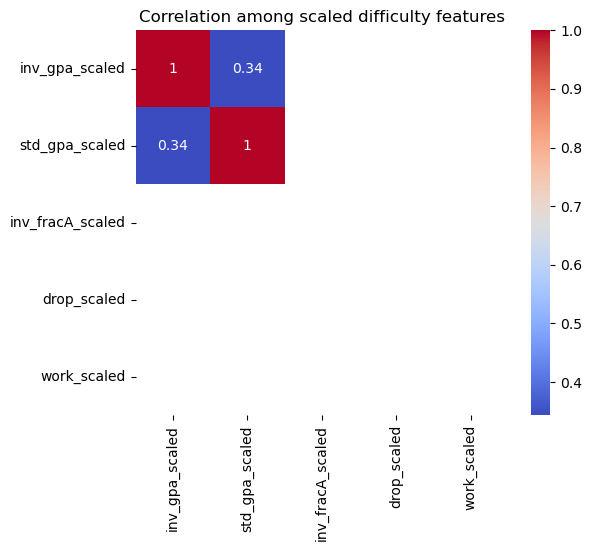

Explained variance ratio: [0.696828 0.303172]


'\nIn many real projects, you might see if the first principal component \nmatches well with our difficulty notion. You could then weigh features \naccording to loadings in that principal component or adjust your hand-tuned \nweights accordingly.\n'

In [5]:
"""
We can do a correlation analysis among the features (inv_gpa, std_gpa, inv_fracA, drop, work)
to see if some are redundant or strongly correlated.
We can also do a quick PCA to see if there's a principal component 
representing an overall 'difficulty' dimension.
"""

# 1) Correlation among raw or scaled features
# We'll look at scaled_df from above
corr_matrix = pd.DataFrame(scaled_values, columns=[col+"_scaled" for col in feature_cols]).corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation among scaled difficulty features")
plt.show()

# 2) PCA example
pca = PCA(n_components=2)
pca_values = pca.fit_transform(scaled_values)  # shape (n_courses, 2)
print("Explained variance ratio:", pca.explained_variance_ratio_)

"""
In many real projects, you might see if the first principal component 
matches well with our difficulty notion. You could then weigh features 
according to loadings in that principal component or adjust your hand-tuned 
weights accordingly.
"""

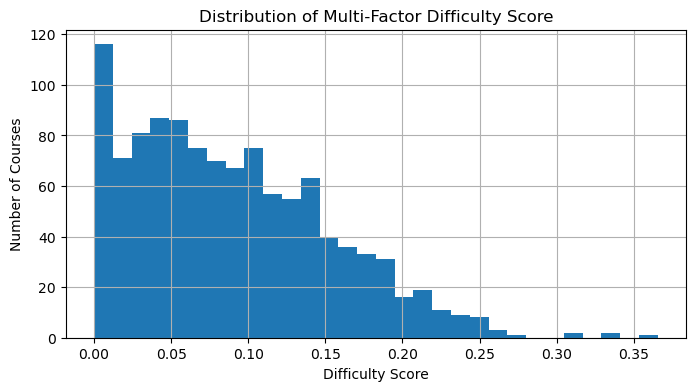

In [6]:
plt.figure(figsize=(8,4))
course_df["difficulty_score"].hist(bins=30)
plt.title("Distribution of Multi-Factor Difficulty Score")
plt.xlabel("Difficulty Score")
plt.ylabel("Number of Courses")
plt.show()

In [7]:
prereq_dict = {
    "CSE 120": ["CSE 100", "CSE 110"],
    "CSE 130": ["CSE 110"],
    "CSE 140": ["CSE 20"],
    "CSE 141L": ["CSE 141"],
    "CSE 230": ["CSE 210", "CSE 110"]
}

G = nx.DiGraph()
for course in course_df.index:
    G.add_node(course)

for course, prereqs in prereq_dict.items():
    if course not in G:
        G.add_node(course)
    for pre in prereqs:
        if pre not in G:
            G.add_node(pre)
        G.add_edge(pre, course)

for c, row in course_df.iterrows():
    if c in G.nodes:
        nx.set_node_attributes(G, {c: row["difficulty_score"]}, name="difficulty_score")

print(f"Graph has {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

Graph has 1115 nodes, 7 edges.


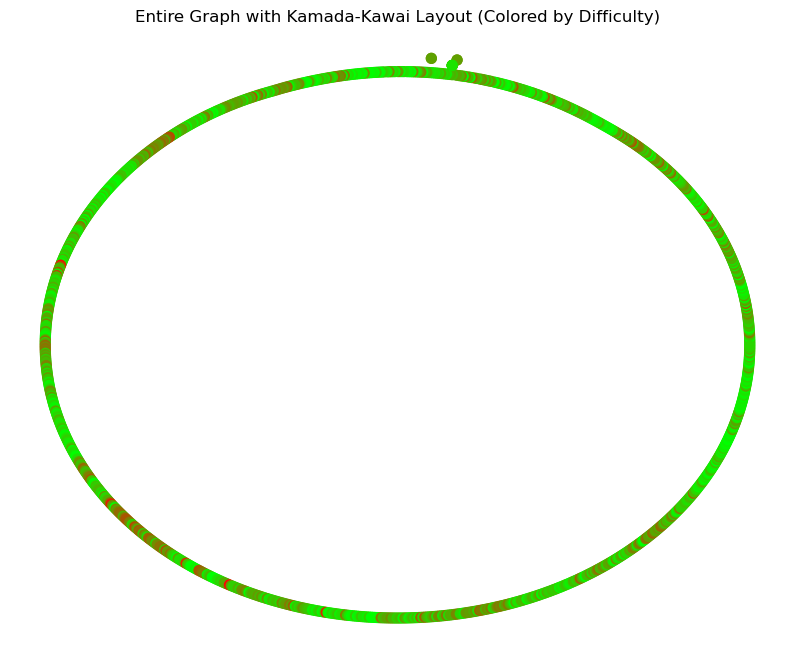

H_focus subgraph: 20 nodes, 0 edges


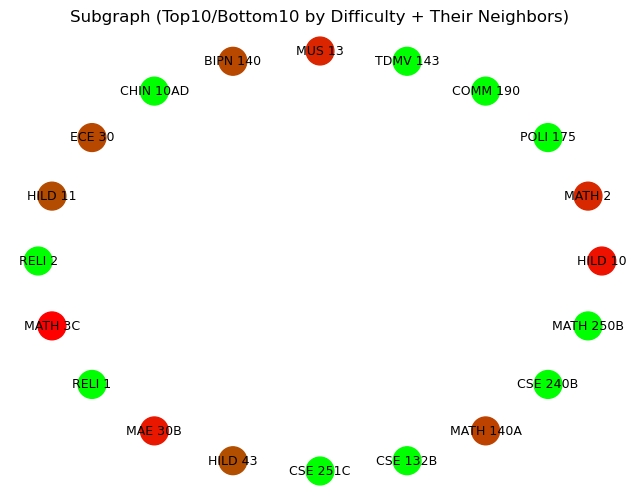

'\nIf you want to export this to Gephi or Cytoscape,\nyou can do:\n\nnx.write_gexf(H_focus, "H_focus.gexf")\n\nThen load "H_focus.gexf" in Gephi for an interactive visualization.\n'

In [8]:
"""
We show different layout approaches:
1) kamada_kawai_layout for the entire graph 
2) Subgraph for top/bottom difficulty 
3) If pygraphviz is installed, we can do nx.drawing.nx_agraph.graphviz_layout
"""

# (A) If the entire graph is large (1000+ nodes), kamada_kawai_layout 
# can sometimes produce more visually separated clusters than spring_layout.
pos_kamada = nx.kamada_kawai_layout(G)
# node color based on difficulty
dvals = [G.nodes[n].get("difficulty_score", 0) for n in G.nodes()]
mn, mx = min(dvals), max(dvals)
rg = mx - mn if mx != mn else 1
def color_map(s):
    nm = (s - mn)/rg
    return (nm, 1-nm, 0)

colors_all = [color_map(s) for s in dvals]

plt.figure(figsize=(10,8))
nx.draw_networkx_edges(G, pos_kamada, alpha=0.2, arrows=False)
nx.draw_networkx_nodes(G, pos_kamada, node_color=colors_all, node_size=50)
plt.title("Entire Graph with Kamada-Kawai Layout (Colored by Difficulty)")
plt.axis("off")
plt.show()

# (B) If you want a layered approach, e.g. graphviz_layout:
# you need pygraphviz installed: `conda install -c conda-forge pygraphviz`
# Then:
# from networkx.drawing.nx_agraph import graphviz_layout
# pos_agraph = graphviz_layout(G, prog="dot")  # or "dot", "twopi", "fdp"...
# ... and then do a draw like above.

# (C) Subgraph focusing only on top10 hardest & top10 easiest
top10 = list(course_df_sorted.head(10).index)
bot10 = list(course_df_sorted.tail(10).index)
focus_nodes = set(top10 + bot10)
# Also add their neighbors 
for c in focus_nodes.copy():
    focus_nodes.update(G.predecessors(c))
    focus_nodes.update(G.successors(c))

H_focus = G.subgraph(focus_nodes).copy()
print(f"H_focus subgraph: {H_focus.number_of_nodes()} nodes, {H_focus.number_of_edges()} edges")

# color by difficulty
hvals = [H_focus.nodes[n].get("difficulty_score",0) for n in H_focus.nodes()]
min_h, max_h = min(hvals), max(hvals)
range_h = max_h - min_h if max_h != min_h else 1
def cfun(x):
    nm = (x - min_h)/range_h
    return (nm, 1-nm, 0)

colors_h = [cfun(x) for x in hvals]

pos_focus = nx.kamada_kawai_layout(H_focus, scale=2)  # or spring_layout
plt.figure(figsize=(8,6))
nx.draw_networkx_edges(H_focus, pos_focus, alpha=0.7, arrowstyle="-|>", arrowsize=12)
nx.draw_networkx_nodes(H_focus, pos_focus, node_color=colors_h, node_size=400)
nx.draw_networkx_labels(H_focus, pos_focus, font_size=9)
plt.title("Subgraph (Top10/Bottom10 by Difficulty + Their Neighbors)")
plt.axis("off")
plt.show()

"""
If you want to export this to Gephi or Cytoscape,
you can do:

nx.write_gexf(H_focus, "H_focus.gexf")

Then load "H_focus.gexf" in Gephi for an interactive visualization.
"""

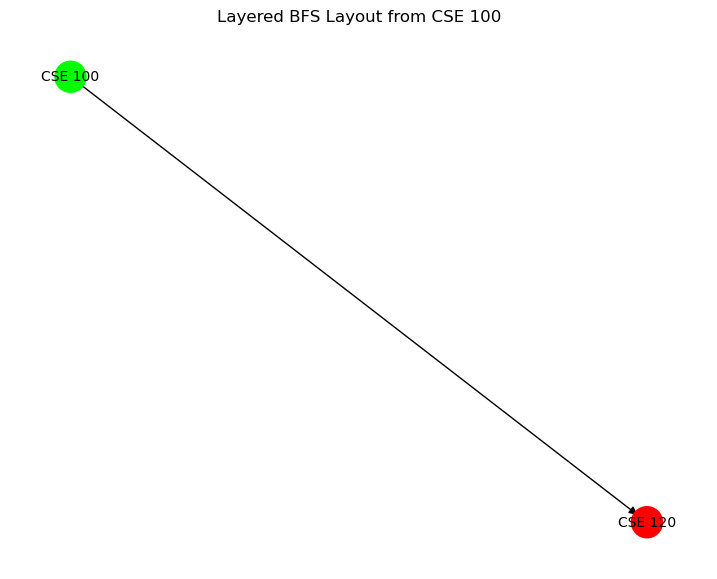

In [9]:
"""
If we want to find multiple shortest paths or a BFS layering from a start node,
we can expand the existing approach. For instance, we might do a BFS layering 
to illustrate "Undergrad -> Intermediate -> Advanced" tiers.
"""

def layered_bfs_layout(graph, start_node):
    """
    Example: do a BFS from start_node to assign 'layer' = distance in edges,
    then place all nodes of layer i in a horizontal line or something.
    This is a naive layout for demonstration.
    """
    from collections import deque
    visited = set()
    queue = deque([(start_node,0)])
    layer_map = {start_node: 0}
    visited.add(start_node)
    while queue:
        node, dist = queue.popleft()
        for nbr in graph.successors(node):
            if nbr not in visited:
                visited.add(nbr)
                layer_map[nbr] = dist+1
                queue.append((nbr, dist+1))
    # now we have a layer for each node that is reachable from start_node
    # place them in x=layer, y=some random or stable offset
    pos = {}
    for n, l in layer_map.items():
        pos[n] = (l, -len(pos)*0.3)  # shift each next node a bit so they don't overlap
    return pos

start_course = "CSE 100"
if start_course in G:
    pos_bfs = layered_bfs_layout(G, start_course)
    sub_bfs_nodes = set(pos_bfs.keys())  # nodes reachable from start_course
    B = G.subgraph(sub_bfs_nodes).copy()

    # color by difficulty
    bscores = [B.nodes[x].get("difficulty_score", 0) for x in B.nodes()]
    mn_b, mx_b = min(bscores), max(bscores)
    rg_b = mx_b - mn_b if mx_b!=mn_b else 1
    def ccol(val):
        norm = (val - mn_b)/rg_b
        return (norm, 1-norm, 0)

    bcolors = [ccol(s) for s in bscores]

    plt.figure(figsize=(9,7))
    nx.draw_networkx_edges(B, pos_bfs, arrowstyle="-|>", arrowsize=12)
    nx.draw_networkx_nodes(B, pos_bfs, node_color=bcolors, node_size=500)
    nx.draw_networkx_labels(B, pos_bfs, font_size=10)
    plt.title(f"Layered BFS Layout from {start_course}")
    plt.axis("off")
    plt.show()
else:
    print(f"{start_course} not in graph, can't BFS layout.")

# Conclusion & Future Directions

1. **Multi-Factor Difficulty Score**:
   - We refined with correlation/PCA analysis to check redundancy among features.
   - Weighted approach can be tuned as more data (drop_rate, workload, project_count) arrives.

2. **Course Graph with Advanced Layouts**:
   - Demonstrated kamada_kawai_layout for the entire graph, subgraph extraction for top/bot difficulty.
   - Showed how to do BFS-based layered layout or use PyGraphviz (`graphviz_layout`) for a more hierarchical display.
   - We can export to `.gexf` or `.graphml` for Gephi/Cytoscape.

3. **Path Analysis**:
   - Single minimal-difficulty path with Dijkstra. 
   - Potentially extended to multiple paths or BFS layering from a start node (undergrad → advanced).
   - Could highlight these paths for better student guidance.

**Next Steps**:
- Once real data for drop_rate, workload, etc. is integrated, re-run correlation/PCA to refine your weighting.
- Possibly implement a "multi-path" or "all shortest paths" approach to show multiple recommended routes.
- Provide an interactive web/GUI front-end for students to query specific start courses, difficulty thresholds, or interest areas.
- Validate or calibrate the difficulty scoring with real feedback from students or actual academic performance.
